In [2]:
import numpy as np

$$\rho(x,y) = ||x-y|| = \sqrt{\sum\limits_{i=1}^N(x_i-y_i)^2}$$

In [2]:
def lp_pairwise_distance(X: np.ndarray, p: int = 2) -> np.ndarray:
    return (np.power(np.abs(X[:, None, :] - X[None, :, :]), p)**(1/p)).sum(axis=-1)

def cos_pairwise_distance(X: np.ndarray) -> np.ndarray:
    f = (X[:, None, :] * X[None, :, :]).sum(axis=-1)
    d = np.sqrt(np.power(X[:, None, :], 2).sum(-1)) * np.sqrt(np.power(X[None, :, :], 2).sum(-1))
    return 1 - f / d

In [3]:
X = np.random.normal(0,1,(3,5))
cos_pairwise_distance(X)

array([[ 1.11022302e-16,  8.33768157e-01,  8.94157308e-01],
       [ 8.33768157e-01, -2.22044605e-16,  5.63243958e-01],
       [ 8.94157308e-01,  5.63243958e-01,  2.22044605e-16]])

In [ ]:
class ConvectionDiffusionEquationSolver1d:

    def __init__(self, 
                 u0: Callable, 
                 ua: Callable, 
                 time_step: float = None, 
                 space_step: float = None, 
                 grid_constr: Callable = None):

        self.u0 = u0
        self.ua = ua
        self.tau = time_step
        self.h = space_step

        if grid_constr is not None:
            self.time_grid_constr = grid_constr
            self.space_grid_constr = grid_constr
        elif grid_constr is None and time_step is not None and space_step is not None:
            self.time_grid_constr = self._grid_step_size(time_step)
            self.space_grid_constr = self._grid_step_size(space_step)
        elif grid_constr is None and time_step is None and space_step is None:
            self.time_grid_constr = lambda val: val
            self.space_grid_constr = lambda val: val
        else:
            raise ValueError("step_size and grid_constr are mutually exclusive arguments.")
    
    @staticmethod
    def _grid_step_size(step_size: float) -> np.ndarray:

        def _grid_constr(val):
            start = val[0]
            end = val[-1]
            niters = int(np.ceil(np.abs(end - start) / step_size + 1))
            return np.linspace(start, end, niters)

        return _grid_constr
    
    @staticmethod
    def _coef_matrix(i, sigma, lam, u):
        
        n = u.shape[1] - 2
        #A = -lam * sigma * np.eye(n, k=1) 
        #A += (1 + 2 * lam * sigma) * np.eye(n)  
        #A -= lam * sigma * np.eye(n, k=-1)

        return A

    @staticmethod
    def _ordinate_values(i, sigma, lam, u):
        
        #b = (1 - 2 * sigma) * lam * u[i-1, 2:]
        #b += 2 * (1 - lam * (1 - 2 * sigma)) * u[i-1, 1:-1] 
        #b += (1 - 2 * sigma) * lam * u[i-1, :-2] 
        #b += sigma * lam * u[i-2, 2:] 
        #b -= (1 + 2 * lam * sigma) * u[i-2, 1:-1] 
        #b += lam * sigma * u[i-2, :-2]

        return b
    
    def __call__(self, t, x, sigma=1.):
        
        u0 = self.u0
        ua = self.ua
        
        time_grid = self.time_grid_constr(t)
        space_grid = self.space_grid_constr(x)

        tau, h = (self.tau, self.h) if self.tau is not None and self.tau is not None \
                         else (time_grid[1] - time_grid[0], space_grid[1] - space_grid[0])
        lam = tau / h 

        assert time_grid[0] == t[0] and time_grid[-1] == t[-1], "grid and real edge points must be equal."
        assert space_grid[0] == x[0] and space_grid[-1] == x[-1], "grid and real edge points must be equal."

        solution = np.empty((*time_grid.shape, *space_grid.shape), dtype=x.dtype)

        solution[0] = u0(space_grid)
        solution[:, 0] = ua(time_grid)
        
        for i in range(2, len(time_grid)):

            A = self._coef_matrix(i, sigma, lam, solution)
            b = self._ordinate_values(i, sigma, lam, solution)

            solution[i, 1:-1] = np.linalg.solve(A,b)

        return solution

In [4]:
class KIR:

    def __init__(self, u0, phi0):

        self.u0 = u0
        self.phi0 = phi0
    
    def __call__(self, t: np.ndarray, x: np.ndarray):
        
        lam = (t[1]-t[0])/(x[1]-x[0])

        u = np.empty((*t.shape, *x.shape))
        u[0] = self.u0(x)
        u[:, 0] = self.phi0(t)
        
        for n in range(len(t)-1):
            for m in range(1,len(x)):
                u[n+1,m] = (1-lam)*u[n,m]+lam*u[n,m-1]

        return u


$$
\begin{cases}
    \dfrac{\partial u(t,x)}{\partial t} + \dfrac{\partial u(t,x)}{\partial x} = 0\\
    u(t_0,x) = u_0(x)\\
    u(t,x_0) = \varphi_0(t)\\
    u(t,x_1) = \varphi_1(t)
\end{cases}
$$

$$
\begin{cases}
    \dfrac{\partial u(t,x)}{\partial t} + \dfrac{\partial u(t,x)}{\partial x} = 0\\
    \frac{\partial u(t_0,x)}{\partial е} = u_0(x)\\
    \frac{\partial u(t,x_0)}{\partial x} = \varphi_0(t)\\
    \frac{\partial u(t,x_1)}{\partial x} = \varphi_1(t)
\end{cases}
$$

$x\in [a,b]$, $t\in [0,t]$

$$\dfrac{\partial u(t,x)}{\partial t} + \dfrac{\partial u(t,x)}{\partial x} = 0$$

$$\dfrac{u^{n+1}_m - u^n_m}{\tau} + \dfrac{u^n_m - u^n_{m-1}}{h} = 0 \Rightarrow$$

$$\Rightarrow \dfrac{1}{\tau}u^{n+1}_m =  \dfrac{1}{\tau}u^n_m - \dfrac{1}{h}u^n_m + u^n_{m-1}\dfrac{1}{h} \Rightarrow u^{n+1}_m = u^n_m -\lambda u^n_m + \lambda u^n_{m-1} \Rightarrow$$

$$\Rightarrow  u^{n+1}_m = (1 - \lambda)u^n_m + \lambda u^n_{m-1}$$

In [5]:
u0 = lambda x: np.cos(np.pi*x)
phi0 = lambda x: np.cos(x)

solver = KIR(u0, phi0)

t = np.linspace(0,1,100)
x = np.linspace(0,2,50)

u = solver(t, x)

In [6]:
import matplotlib.pyplot as plt

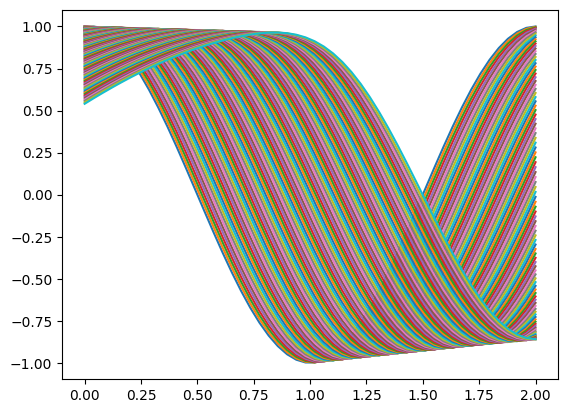

In [7]:
for i in range(100):
    plt.plot(x, u[i, :])
plt.show()

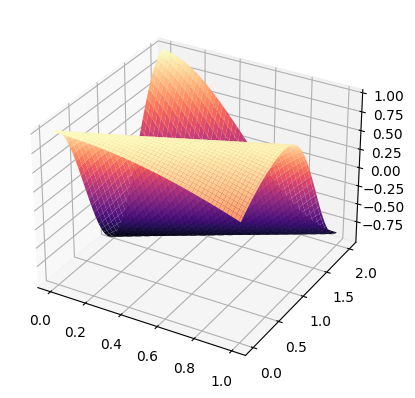

In [8]:
ax = plt.figure().add_subplot(projection='3d')

T, X = np.meshgrid(t, x)

# Create an empty array of strings with the same shape as the meshgrid, and
# populate it with two colors in a checkerboard pattern

# Plot the surface with face colors taken from the array we made.
surf = ax.plot_surface(T, X, u.T, cmap='magma', linewidth=0)

# Customize the z axis.
plt.show()

$$\dfrac{u^{n}_m - u^{n-1}_m}{h} = u_t' \Rightarrow u^{n-1}_m = u^{n}_m - hu_t'$$

$$
u^{n+1}_m = \lambda u^n_{m+1} + 2 (1 - \lambda)u^n_m + \lambda u^n_{m-1} - u^{n-1}_m
$$

In [9]:

def wave1d(t, x, u0, ut0, ua, ub):

    lam = ((t[1]-t[0])/(x[1]-x[0]))**2

    u = np.empty((*t.shape, *x.shape))

    u[0] = u0(x)
    u[1] = u0(x) + (t[1]-t[0])*ut0(x)
    u[:, 0] = ua(t)
    u[:, -1] = ub(t)

    for i in range(2, len(t)):
        u[i, 1:-1] = lam * u[i-1, 2:] + 2 * (1 - lam) * u[i-1, 1:-1] + lam * u[i-1, :-2] - u[i-2, 1:-1]
    
    return u

$$
\dfrac{u_m^{n+1} - 2u_m^n + u^{n-1}_m}{\tau^2} = \dfrac{u_{m+1}^{n+1} - u^{n+1}_m - u_m^{n-1} + u_{m-1}^{n-1}}{h^2}
$$

$$
- \dfrac{1}{h^2}u^{n+1}_{m+1} + \left(\dfrac{1}{\tau^2} + \dfrac{1}{h^2}\right)u^{n+1}_m = \dfrac{2}{\tau^2}u^n_m - \left(\dfrac{1}{\tau^2} + \dfrac{1}{h^2}\right)u^{n-1}_m + \dfrac{1}{h^2}u^{n-1}_{m-1}
$$

$$
-\lambda u^{n+1}_{m+1} + (1+\lambda)u^{n+1}_m = 2u^n_m - (1 + \lambda)u^{n-1}_m + \lambda u^{n-1}_{m-1}
$$

In [10]:

def wave1d(t, x, u0, ut0, ua, ub):

    lam = ((t[1]-t[0])/(x[1]-x[0]))**2

    u = np.ones((*t.shape, *x.shape)) * np.nan

    u[0] = u0(x)
    u[1] = u0(x) + (t[1]-t[0])*ut0(x)
    u[:, 0] = ua(t)
    u[:, -1] = ub(t)
    
    for i in range(2, len(t)):
        n = u.shape[1] - 2
        A = -lam * np.eye(n, k=1) + (1+lam) * np.eye(n)
        b = 2 * u[i-1, 1:-1] - (1 + lam) * u[i-2, 1:-1] + lam * u[i-2, :-2]
        u[i, 1:-1] = np.linalg.solve(A,b)
    
    return u

$$
-\lambda\sigma u^{n+1}_{m+1} + (1 + 2\sigma\lambda)u^{n+1}_m - \sigma\lambda u^{n+1}_{m-1} = (1-2\sigma)\lambda u^n_{m+1} + (2 - 2\lambda(1-2\sigma))u^n_m + (1 - 2\sigma)\lambda u^n_{m-1} + \sigma\lambda u^{n-1}_{m+1} - (1 - 2\lambda\sigma)u^{n-1}_m + \lambda\sigma u^{n-1}_{m-1}
$$

In [11]:
def wave1d(t, x, u0, ut0, ua, ub):

    sigma = 0.3
    lam = ((t[1]-t[0])/(x[1]-x[0]))**2

    u = np.ones((*t.shape, *x.shape)) * np.nan

    u[0] = u0(x)
    u[1] = u0(x) + (t[1]-t[0])*ut0(x)
    u[:, 0] = ua(t)
    u[:, -1] = ub(t)
    
    for i in range(2, len(t)):
        n = u.shape[1] - 2
        A = -lam * sigma * np.eye(n, k=1) + (1+2*lam*sigma) * np.eye(n)  - lam * sigma * np.eye(n, k=-1)
        b = (1 - 2*sigma)*lam*u[i-1, 2:] + 2*(1-lam*(1-2*sigma))*u[i-1, 1:-1] + (1-2*sigma)*lam*u[i-1, :-2] + sigma*lam*u[i-2, 2:] - (1+2*lam*sigma)*u[i-2, 1:-1] + lam*sigma*u[i-2, :-2]
        u[i, 1:-1] = np.linalg.solve(A,b)
    
    return u

In [12]:
from typing import Callable

In [112]:
from math import ceil, floor
from numeric.sde import WaveEquationSolver1d


t0, t1 = 0, 4 * np.pi
x0, x1 = 0, 2 * np.pi
t = np.linspace(t0,t1,200)
x = np.linspace(x0,x1,200)

solver = WaveEquationSolver1d(lambda t: np.zeros_like(t), lambda t: np.exp(-(x-1)**2)*np.arctan(t), lambda t: np.zeros_like(t), lambda t: np.zeros_like(t))
u = solver(t, x)

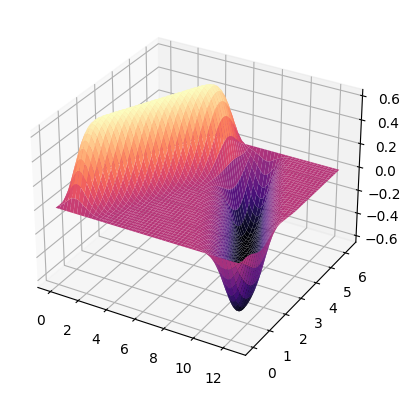

In [113]:
ax = plt.figure().add_subplot(projection='3d')

T, X = np.meshgrid(t, x)

# Create an empty array of strings with the same shape as the meshgrid, and
# populate it with two colors in a checkerboard pattern

# Plot the surface with face colors taken from the array we made.
surf = ax.plot_surface(T, X, u.T, cmap='magma', linewidth=0)

# Customize the z axis.
plt.show()

<Figure size 640x480 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

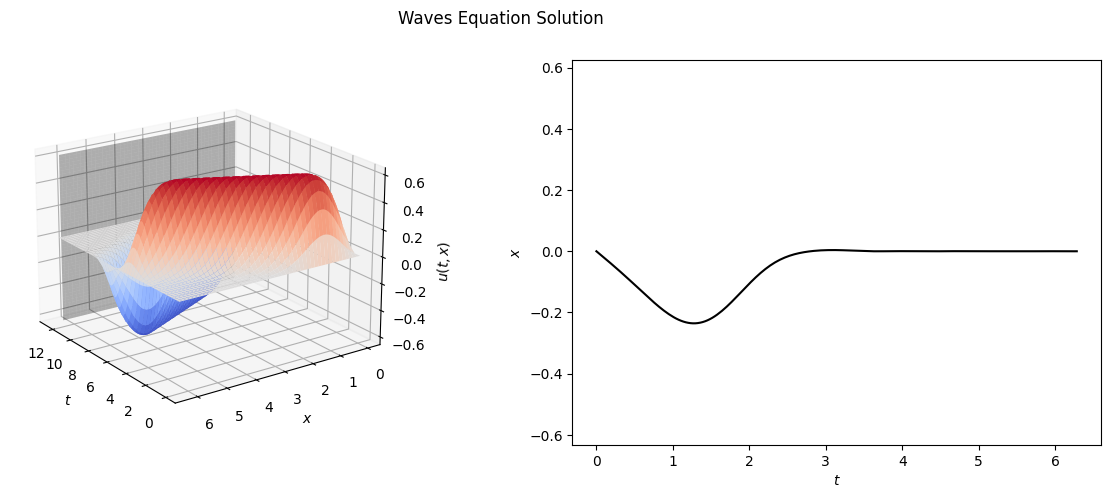

In [114]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

nums = len(t)
T, X = np.meshgrid(solver.time_grid_constr(t), solver.space_grid_constr(x))

for i in range(0, nums, 5):

    plt.clf()

    fig = plt.figure(figsize=(15,5));
    plt.suptitle("Waves Equation Solution")
    ax1 = plt.subplot(121, projection='3d')
    ax2 = plt.subplot(122)
    
    surf = ax1.plot_surface(T, X, u.T, cmap='coolwarm', linewidth=0)
    ax1.set_xlabel("$t$")
    ax1.set_ylabel("$x$")
    ax1.set_zlabel("$u(t,x)$")
    angle = 360 / nums * i
    ax1.view_init(20, 145)

    ax2.plot(x, u[i, :], color='k')
    ax2.set_ylim(u.min(), u.max())
    ax2.set_xlabel("$t$")
    ax2.set_ylabel("$x$")

    newcmp = ListedColormap( np.array([0, 0, 0, 1]))
    surf = ax1.plot_surface(np.ones_like(X)*t[i], X.T, np.linspace(u.min(),u.max(),np.prod(X.shape)).reshape(X.shape), cmap=newcmp, alpha=0.3, linewidth=0)

    plt.savefig(f'assets/waves/{i}.png')
    clear_output()

In [115]:
import imageio

images = []
for filename in [f'assets/waves/{i}.png' for i in range(0, len(t), 5)]:
    images.append(imageio.imread(filename))
imageio.mimsave('assets/waves.gif', images)

/var/folders/qg/xpf_3z654rz2wkstrmbrx7_00000gn/T/ipykernel_17436/1150687137.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))


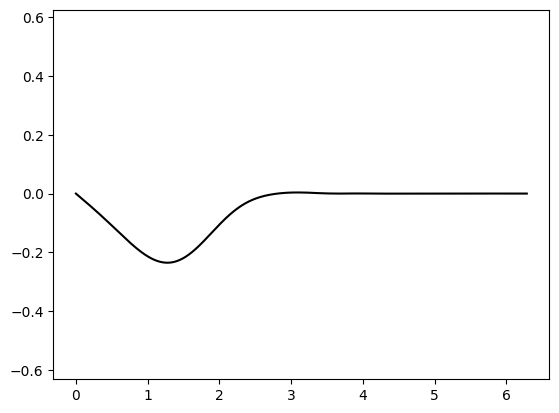

In [17]:
for i in range(0, len(t), 5):
    plt.clf()
    plt.plot(x, u[i, :], color='k')
    plt.ylim(u.min(), u.max())
    plt.savefig(f'assets/waves/{i}.png')

In [116]:
from numeric.sde import DiffusionEquationSolver1d

t0, t1 = 0, 4
x0, x1 = 0, 2 * np.pi
t = np.linspace(t0,t1,200)
x = np.linspace(x0,x1,200)

solver = DiffusionEquationSolver1d(lambda x: np.sin(x), lambda x: np.zeros_like(x), lambda x: np.zeros_like(x))
u = solver(t, x, sigma=1.)

<Figure size 640x480 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

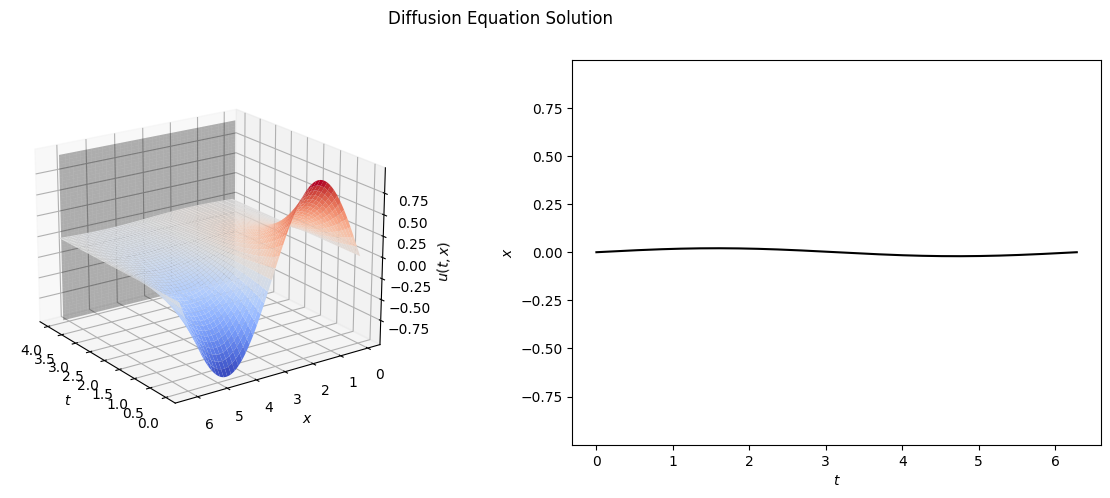

In [118]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

nums = len(t)
T, X = np.meshgrid(solver.time_grid_constr(t), solver.space_grid_constr(x))

for i in range(0, nums, 5):

    plt.clf()

    fig = plt.figure(figsize=(15,5));
    plt.suptitle("Diffusion Equation Solution")
    ax1 = plt.subplot(121, projection='3d')
    ax2 = plt.subplot(122)
    
    surf = ax1.plot_surface(T, X, u.T, cmap='coolwarm', linewidth=0)
    ax1.set_xlabel("$t$")
    ax1.set_ylabel("$x$")
    ax1.set_zlabel("$u(t,x)$")
    angle = 360 / nums * i
    ax1.view_init(20, 145)

    ax2.plot(x, u[i, :], color='k')
    ax2.set_ylim(u.min(), u.max())
    ax2.set_xlabel("$t$")
    ax2.set_ylabel("$x$")

    newcmp = ListedColormap( np.array([0, 0, 0, 1]))
    surf = ax1.plot_surface(np.ones_like(X)*t[i], X.T, np.linspace(u.min(),u.max(),np.prod(X.shape)).reshape(X.shape), cmap=newcmp, alpha=0.3, linewidth=0)

    plt.savefig(f'assets/diffusion/{i}.png')
    clear_output()

In [119]:
import imageio

images = []
for filename in [f'assets/diffusion/{i}.png' for i in range(0, len(t), 5)]:
    images.append(imageio.imread(filename))
imageio.mimsave('assets/diffusion.gif', images)

/var/folders/qg/xpf_3z654rz2wkstrmbrx7_00000gn/T/ipykernel_17436/2823193995.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))
